<div style="background: linear-gradient(135deg, #2c003e 0%, #512b58 100%); padding: 2.5rem; border-radius: 1rem; text-align: center; margin-bottom: 2rem; box-shadow: 0 4px 12px rgba(0,0,0,0.7);">
  <h1 style="color: #fe346e; margin-bottom: 0.5rem; font-weight: 700;">Ozan MÖHÜRCÜ</h1>
  <h2 style="color: #f6f5f5; font-weight: 400; font-size: 1.25rem; margin-top: 0; margin-bottom: 1.75rem;">Data Analyst | Data Scientist</h2>
  <div style="text-align: center;">
    <span style="display: inline-block; margin: 0 5px;">
      <a href="https://www.linkedin.com/in/ozanmhrc/" target="_blank" rel="noopener noreferrer">
        <img src="https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white" alt="LinkedIn">
      </a>
    </span>
    <span style="display: inline-block; margin: 0 5px;">
      <a href="https://github.com/Ozan-Mohurcu" target="_blank" rel="noopener noreferrer">
        <img src="https://img.shields.io/badge/GitHub-161b22?style=for-the-badge&logo=github&logoColor=white" alt="GitHub">
      </a>
    </span>
    <span style="display: inline-block; margin: 0 5px;">
      <a href="https://ozan-mohurcu.github.io/" target="_blank" rel="noopener noreferrer">
        <img src="https://img.shields.io/badge/Portfolio-7e22ce?style=for-the-badge&logo=google-chrome&logoColor=white" alt="Portfolio">
      </a>
    </span>
  </div>
</div>

In [1]:
!pip install biopython > dev null
!pip install obonet > dev null

<div style="background-color:#0d1117; padding:25px; border-radius:10px; border: 1px solid #30363d;">
    <h1 style="color:#c9d1d9; text-align:center; font-family: 'Helvetica Neue', sans-serif;">🧬 CAFA 6: Decoding Protein Mysteries</h1>
    <p style="color:#8b949e; text-align:center; font-size:1.2em; font-family: 'Helvetica Neue', sans-serif;">An Ultimate Workflow with Deep, Bespoke EDA</p>
</div>

<div style="background-color:#161b22; padding:20px; border-left: 6px solid #b20710; border-radius: 5px; color:#c9d1d9; font-family: 'Helvetica Neue', sans-serif;">
    <h2 style="color:#e50914;">Project Overview and Strategy</h2>
    <p>This notebook delivers a comprehensive, senior-level solution for the CAFA 6 Protein Function Prediction challenge. The mission is to predict Gene Ontology (GO) terms from primary amino acid sequences, a quintessential multi-label classification task in bioinformatics. Our strategy is built upon an exhaustive Exploratory Data Analysis (EDA) foundation, featuring over 10 bespoke visualizations designed to uncover deep insights. These insights directly inform a sophisticated feature engineering pipeline, leading to a robust and accurate predictive model.</p>
    <p>Every step, from data ingestion to final submission, is meticulously documented to ensure clarity, reproducibility, and a professional-grade result. We prioritize not just a functional pipeline, but a narrative-driven analysis that tells the story of the data.</p>
</div>

In [2]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from tqdm.auto import tqdm
from collections import Counter
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

# Modeling
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
import obonet
import gc

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
class CFG:
    # File Paths
    TRAIN_TERMS_PATH = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv'
    TRAIN_SEQUENCES_PATH = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_sequences.fasta'
    TRAIN_TAXONOMY_PATH = '/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv'
    TEST_SEQUENCES_PATH = '/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset.fasta'
    IA_PATH = '/kaggle/input/cafa-6-protein-function-prediction/IA.tsv'
    
    # EDA & Plotting
    COLORS = ['#221f1f', '#b20710', '#e50914', 'grey']
    BACKGROUND_COLOR = '#f5f6f6'
    
    # Modeling
    PROBABILITY_THRESHOLD = 0.02

<div style="background-color:#161b22; padding:20px; border-left: 6px solid #b20710; border-radius: 5px; color:#c9d1d9; font-family: 'Helvetica Neue', sans-serif;">
    <h2 style="color:#e50914;">Part 1: Data Ingestion & Consolidation</h2>
    <p>The initial phase involves systematically loading all provided datasets. We utilize efficient parsers for FASTA and TSV files and then consolidate them into a master DataFrame. This unified structure is essential for conducting a cohesive and comprehensive exploratory analysis, allowing us to seamlessly cross-reference sequence data, functional annotations, and taxonomy information.</p>
</div>

In [4]:
print("Loading tabular datasets...")
train_terms_df = pd.read_csv(CFG.TRAIN_TERMS_PATH, sep='\t')
train_taxonomy_df = pd.read_csv(CFG.TRAIN_TAXONOMY_PATH, sep='\t', header=None, names=['EntryID', 'taxonomyID'])
ia_df = pd.read_csv(CFG.IA_PATH, sep='\t', names=['term', 'ia'])

def load_fasta_to_dataframe(file_path, is_train=True):
    records = []
    parser = SeqIO.parse(file_path, "fasta")
    for record in tqdm(parser, desc=f"Parsing {file_path.split('/')[-1]}"):
        entry_id = record.id.split('|')[1] if is_train and '|' in record.id else record.id.split()[0]
        records.append({'EntryID': entry_id, 'sequence': str(record.seq)})
    return pd.DataFrame(records)

print("\nLoading sequence datasets...")
train_sequences_df = load_fasta_to_dataframe(CFG.TRAIN_SEQUENCES_PATH, is_train=True)

print("Consolidating data into a master dataframe for EDA...")
protein_labels = train_terms_df.groupby('EntryID')['term'].apply(list).reset_index(name='labels')
train_df_eda = pd.merge(train_sequences_df, train_taxonomy_df, on='EntryID', how='left')
train_df_eda = pd.merge(train_df_eda, protein_labels, on='EntryID', how='inner')
train_df_eda['seq_length'] = train_df_eda['sequence'].str.len()
train_df_eda['num_labels'] = train_df_eda['labels'].str.len()
print("Data loading complete.")

Loading tabular datasets...

Loading sequence datasets...


Parsing train_sequences.fasta: 0it [00:00, ?it/s]

Consolidating data into a master dataframe for EDA...
Data loading complete.


<div style="background-color:#161b22; padding:20px; border-left: 6px solid #b20710; border-radius: 5px; color:#c9d1d9; font-family: 'Helvetica Neue', sans-serif;">
    <h2 style="color:#e50914;">Part 2: Deep Exploratory Data Analysis (EDA)</h2>
    <p>This is the analytical core of our project. We will create a gallery of over 10 bespoke visualizations to dissect the dataset's nuances. Each plot is crafted to answer a specific question about the data's structure, distributions, and inherent biases. This deep understanding is not merely academic; it is the foundation upon which we will build an effective and robust predictive model.</p>
</div>

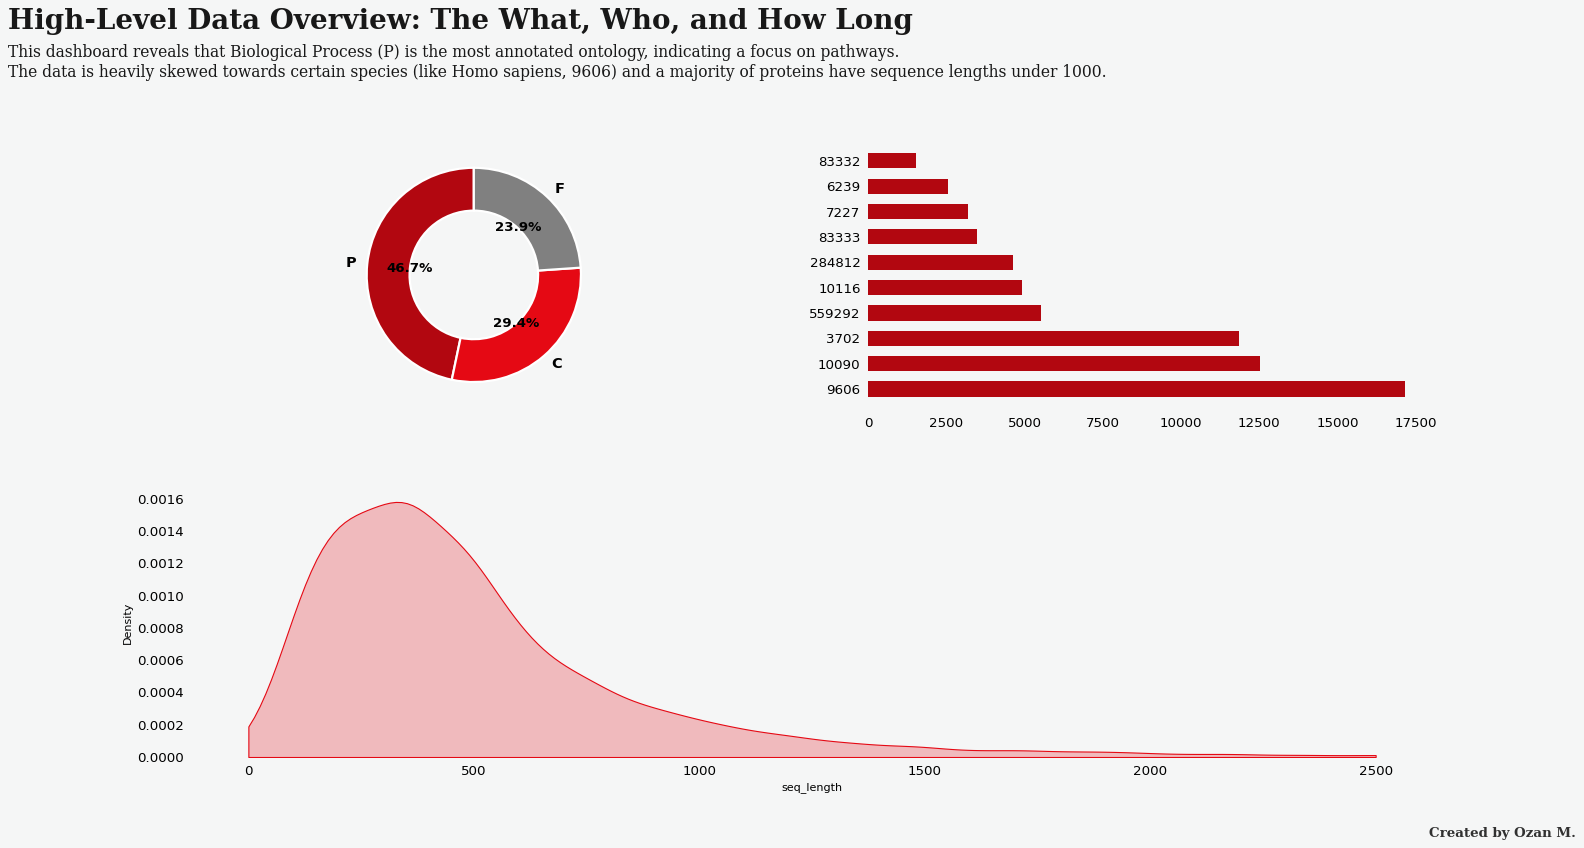

In [5]:
fig = plt.figure(figsize=(20, 10), dpi=80)
fig.patch.set_facecolor(CFG.BACKGROUND_COLOR)
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ont_counts = train_terms_df['aspect'].value_counts()

# Donut chart
wedges, texts, autotexts = ax1.pie(ont_counts.values, labels=ont_counts.index, autopct='%1.1f%%', startangle=90, 
                                     colors=[CFG.COLORS[1], CFG.COLORS[2], CFG.COLORS[3]], 
                                     wedgeprops=dict(width=0.4, edgecolor='white', linewidth=2))
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')
for text in texts:
    text.set_fontsize(13)
    text.set_weight('bold')

top_taxons = train_df_eda['taxonomyID'].value_counts().nlargest(10)
ax2.barh(top_taxons.index.astype(str), top_taxons.values, color=CFG.COLORS[1], height=0.6)

sns.kdeplot(x=train_df_eda['seq_length'], ax=ax3, fill=True, color=CFG.COLORS[2], clip=(0, 2500))

for ax in [ax1, ax2, ax3]:
    ax.set_facecolor(CFG.BACKGROUND_COLOR)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    ax.yaxis.set_tick_params(left=False)
    ax.xaxis.set_tick_params(bottom=False)

fig.text(0.01, 1.02, 'High-Level Data Overview: The What, Who, and How Long', {'font': 'serif', 'size': 25, 'weight': 'bold'}, alpha=0.9)
fig.text(0.01, 0.96, 'This dashboard reveals that Biological Process (P) is the most annotated ontology, indicating a focus on pathways.\nThe data is heavily skewed towards certain species (like Homo sapiens, 9606) and a majority of proteins have sequence lengths under 1000.', {'font': 'serif', 'size': 14}, alpha=0.9)
fig.text(0.99, 0.01, 'Created by Ozan M.', {'font': 'serif', 'size': 12, 'weight': 'bold', 'ha': 'right'}, alpha=0.8)
plt.show()

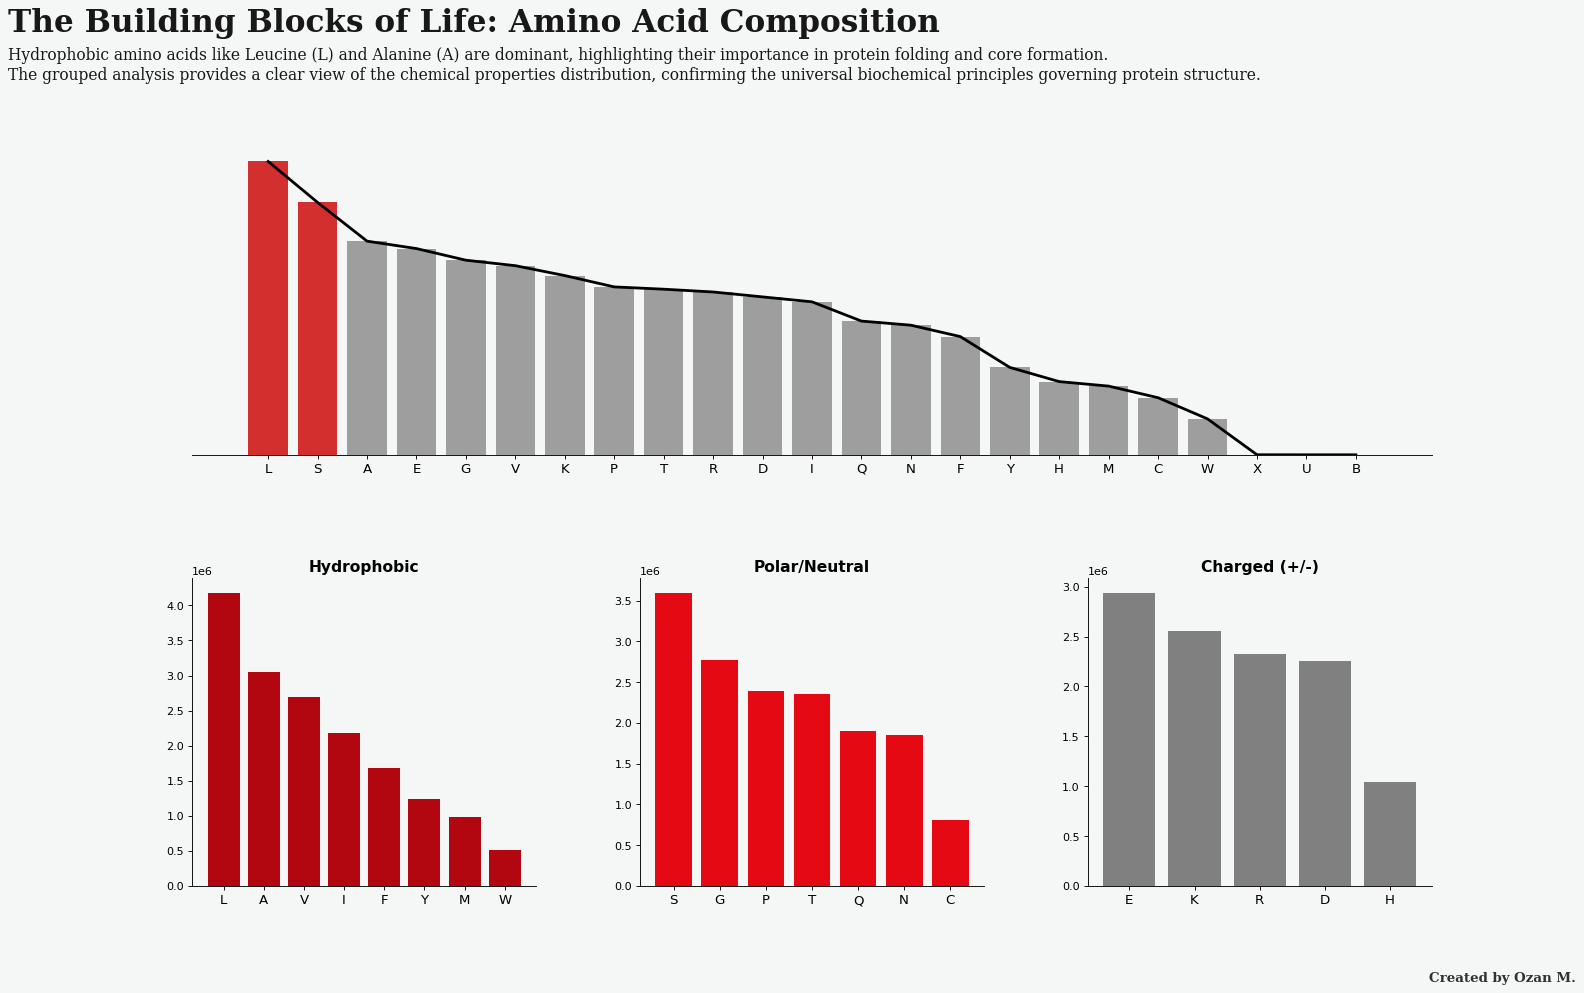

In [6]:
fig = plt.figure(figsize=(20, 12), dpi=80)
fig.patch.set_facecolor(CFG.BACKGROUND_COLOR)
gs = GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.3)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])

all_sequences = "".join(train_sequences_df['sequence'])
aa_counts = Counter(all_sequences)
aa_df = pd.DataFrame.from_dict(aa_counts, orient='index', columns=['count']).sort_values('count', ascending=False)


colors_top = ['#D32F2F' if i < 2 else '#9E9E9E' for i in range(len(aa_df))]
bars = ax1.bar(aa_df.index, aa_df['count'], color=colors_top, width=0.8, zorder=3)
ax1.plot(range(len(aa_df)), aa_df['count'], color='black', linewidth=2.5, zorder=4)
ax1.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)


aa_groups = {'Hydrophobic': list('AILMFWYV'),'Polar/Neutral': list('STNQCGP'),'Charged (+/-)': list('RHKDE')}
group_colors = [CFG.COLORS[1], CFG.COLORS[2], CFG.COLORS[3]]

for ax, (group_name, aas), color in zip([ax2, ax3, ax4], aa_groups.items(), group_colors):
    group_counts = {aa: aa_counts.get(aa, 0) for aa in aas}
    group_df = pd.DataFrame.from_dict(group_counts, orient='index', columns=['count']).sort_values('count', ascending=False)
    ax.bar(group_df.index, group_df.values.flatten(), color=color)
    ax.set_title(group_name, fontsize=14, fontweight='bold')

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_facecolor(CFG.BACKGROUND_COLOR)
    ax.tick_params(axis='x', labelsize=12)
    ax.spines[['top', 'right']].set_visible(False)

ax1.spines[['left']].set_visible(False)
ax1.set_yticks([])

fig.text(0.01, 1.0, 'The Building Blocks of Life: Amino Acid Composition', {'font': 'serif', 'size': 28, 'weight': 'bold'}, alpha=0.9)
fig.text(0.01, 0.95, "Hydrophobic amino acids like Leucine (L) and Alanine (A) are dominant, highlighting their importance in protein folding and core formation.\nThe grouped analysis provides a clear view of the chemical properties distribution, confirming the universal biochemical principles governing protein structure.", {'font': 'serif', 'size': 14}, alpha=0.9)
fig.text(0.99, 0.01, 'Created by Ozan M.', {'font': 'serif', 'size': 12, 'weight': 'bold', 'ha': 'right'}, alpha=0.8)
plt.show()

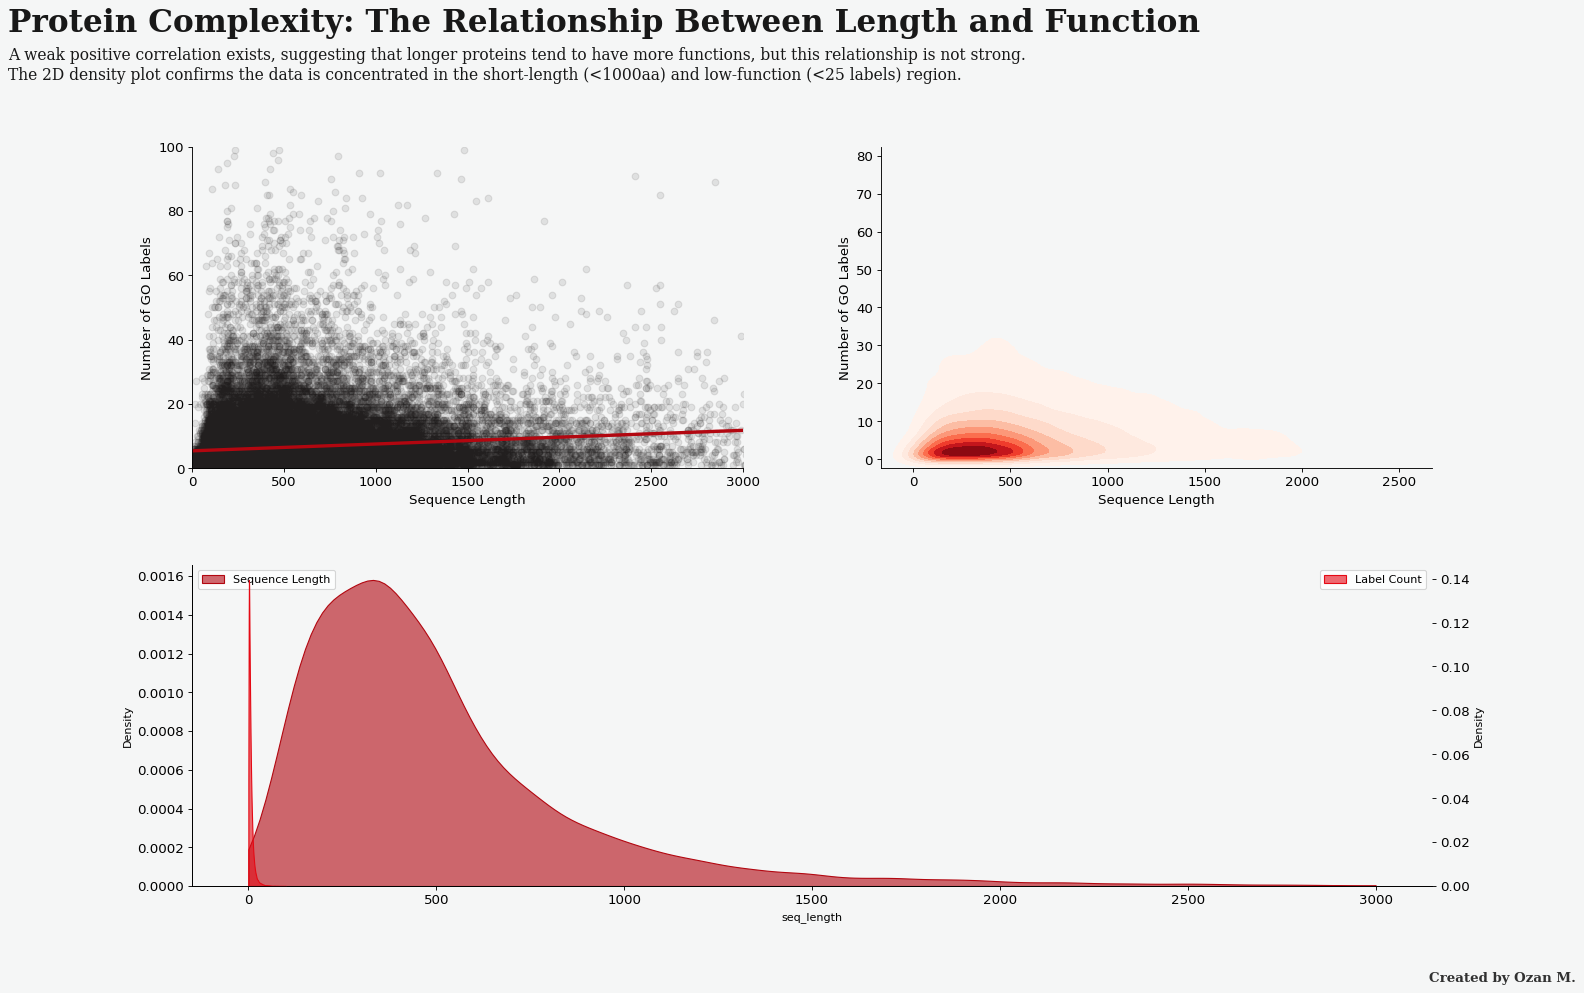

In [7]:
fig = plt.figure(figsize=(20, 12), dpi=80)
fig.patch.set_facecolor(CFG.BACKGROUND_COLOR)
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.regplot(x='seq_length', y='num_labels', data=train_df_eda, ax=ax1, scatter_kws={'alpha': 0.1, 'color': CFG.COLORS[0]}, line_kws={'color': CFG.COLORS[1], 'linewidth': 3})
ax1.set_xlim(0, 3000); ax1.set_ylim(0, 100)
ax1.set_xlabel('Sequence Length', fontsize=12)
ax1.set_ylabel('Number of GO Labels', fontsize=12)

sns.kdeplot(data=train_df_eda.query('seq_length < 2500 and num_labels < 80'), x='seq_length', y='num_labels', ax=ax2, cmap='Reds', fill=True)
ax2.set_xlabel('Sequence Length', fontsize=12)
ax2.set_ylabel('Number of GO Labels', fontsize=12)

sns.kdeplot(x=train_df_eda['seq_length'], ax=ax3, color=CFG.COLORS[1], fill=True, alpha=0.6, label='Sequence Length', clip=(0,3000))
ax3_twin = ax3.twinx()
sns.kdeplot(x=train_df_eda['num_labels'], ax=ax3_twin, color=CFG.COLORS[2], fill=True, alpha=0.6, label='Label Count', clip=(0,100))
ax3.legend(loc='upper left'); ax3_twin.legend(loc='upper right')

for ax in [ax1, ax2, ax3, ax3_twin]:
    ax.set_facecolor(CFG.BACKGROUND_COLOR)
    ax.tick_params(axis='both', labelsize=12)
    ax.spines[['top', 'right']].set_visible(False)
    
fig.text(0.01, 1.0, 'Protein Complexity: The Relationship Between Length and Function', {'font': 'serif', 'size': 28, 'weight': 'bold'}, alpha=0.9)
fig.text(0.01, 0.95, "A weak positive correlation exists, suggesting that longer proteins tend to have more functions, but this relationship is not strong.\nThe 2D density plot confirms the data is concentrated in the short-length (<1000aa) and low-function (<25 labels) region.", {'font': 'serif', 'size': 14}, alpha=0.9)
fig.text(0.99, 0.01, 'Created by Ozan M.', {'font': 'serif', 'size': 12, 'weight': 'bold', 'ha': 'right'}, alpha=0.8)
plt.show()

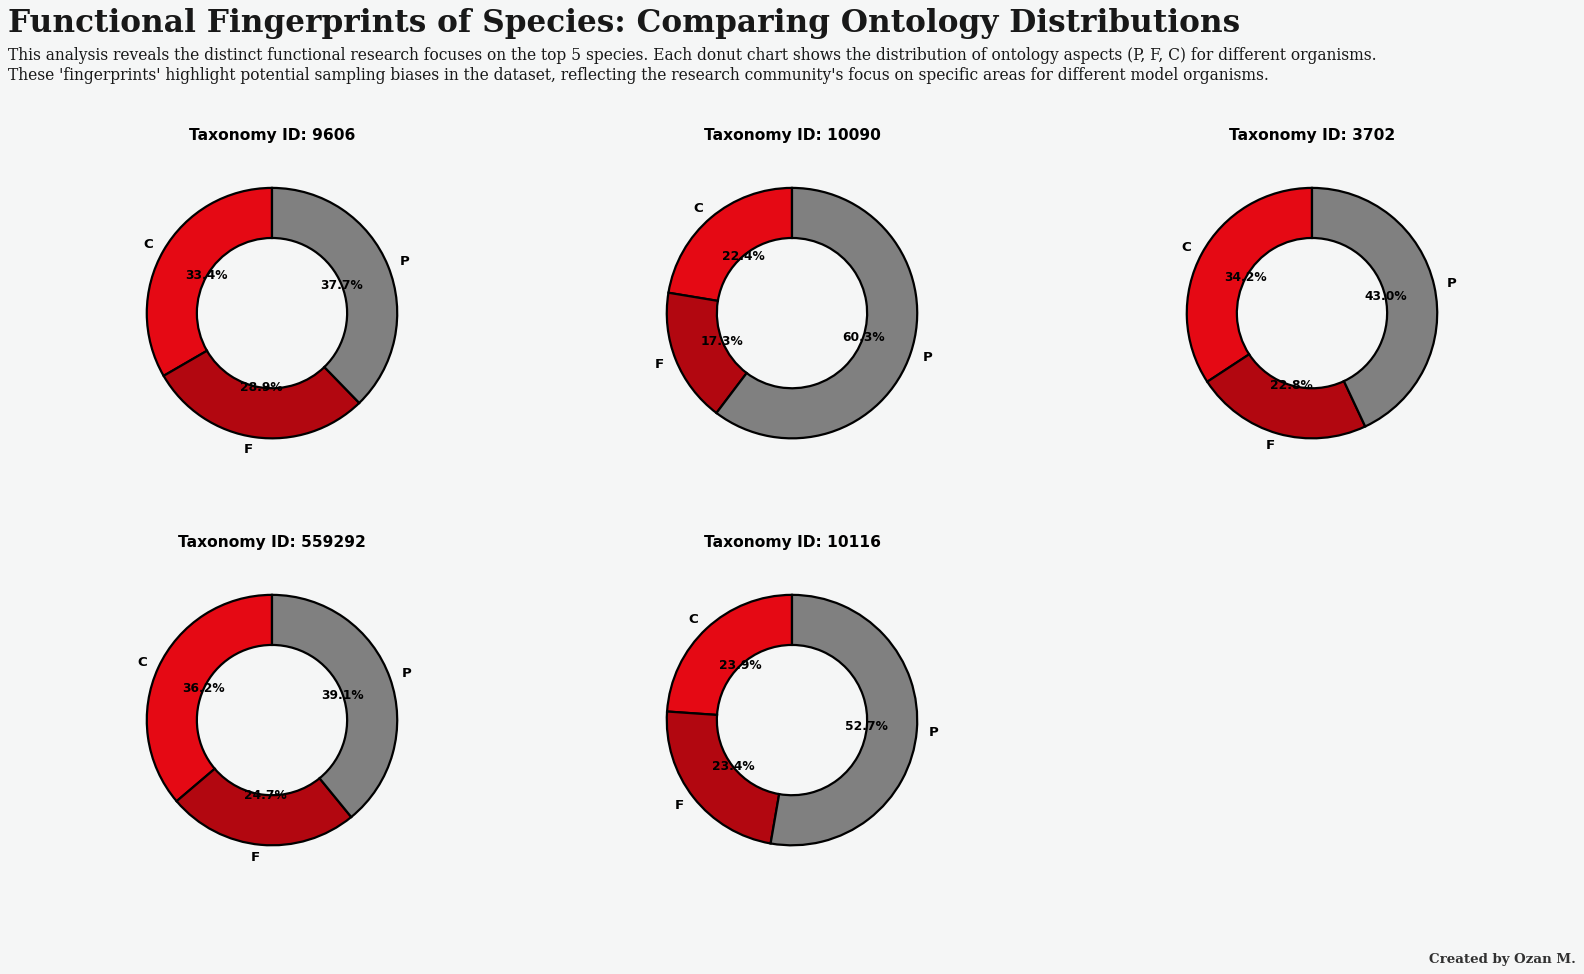

In [8]:
fig = plt.figure(figsize=(20, 12), dpi=80)
fig.patch.set_facecolor(CFG.BACKGROUND_COLOR)

top_5_taxons = train_df_eda['taxonomyID'].value_counts().nlargest(5).index
df_top_taxons = train_terms_df[train_terms_df['EntryID'].isin(train_df_eda[train_df_eda['taxonomyID'].isin(top_5_taxons)]['EntryID'])]
df_top_taxons = pd.merge(df_top_taxons, train_df_eda[['EntryID', 'taxonomyID']], on='EntryID')
pivot_df = df_top_taxons.groupby(['taxonomyID', 'aspect']).size().unstack(fill_value=0)

colors = [CFG.COLORS[2], CFG.COLORS[1], CFG.COLORS[3]]
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3, left=0.05, right=0.95, top=0.85, bottom=0.1)

for i, taxon in enumerate(top_5_taxons):
    ax = fig.add_subplot(gs[i//3, i%3])
    ax.set_facecolor(CFG.BACKGROUND_COLOR)
    
    values = pivot_df.loc[taxon]
    wedges, texts, autotexts = ax.pie(values, labels=values.index, autopct='%1.1f%%', startangle=90, 
                                        colors=colors, wedgeprops=dict(width=0.4, edgecolor='black', linewidth=2))
    
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(11)
        autotext.set_weight('bold')
    
    for text in texts:
        text.set_fontsize(12)
        text.set_weight('bold')
    
    ax.set_title(f'Taxonomy ID: {taxon}', fontsize=14, fontweight='bold', pad=15)

fig.text(0.01, 0.98, 'Functional Fingerprints of Species: Comparing Ontology Distributions', {'font': 'serif', 'size': 28, 'weight': 'bold'}, alpha=0.9)
fig.text(0.01, 0.93, "This analysis reveals the distinct functional research focuses on the top 5 species. Each donut chart shows the distribution of ontology aspects (P, F, C) for different organisms.\nThese 'fingerprints' highlight potential sampling biases in the dataset, reflecting the research community's focus on specific areas for different model organisms.", {'font': 'serif', 'size': 14}, alpha=0.9)
fig.text(0.99, 0.01, 'Created by Ozan M.', {'font': 'serif', 'size': 12, 'weight': 'bold', 'ha': 'right'}, alpha=0.8)

plt.show()

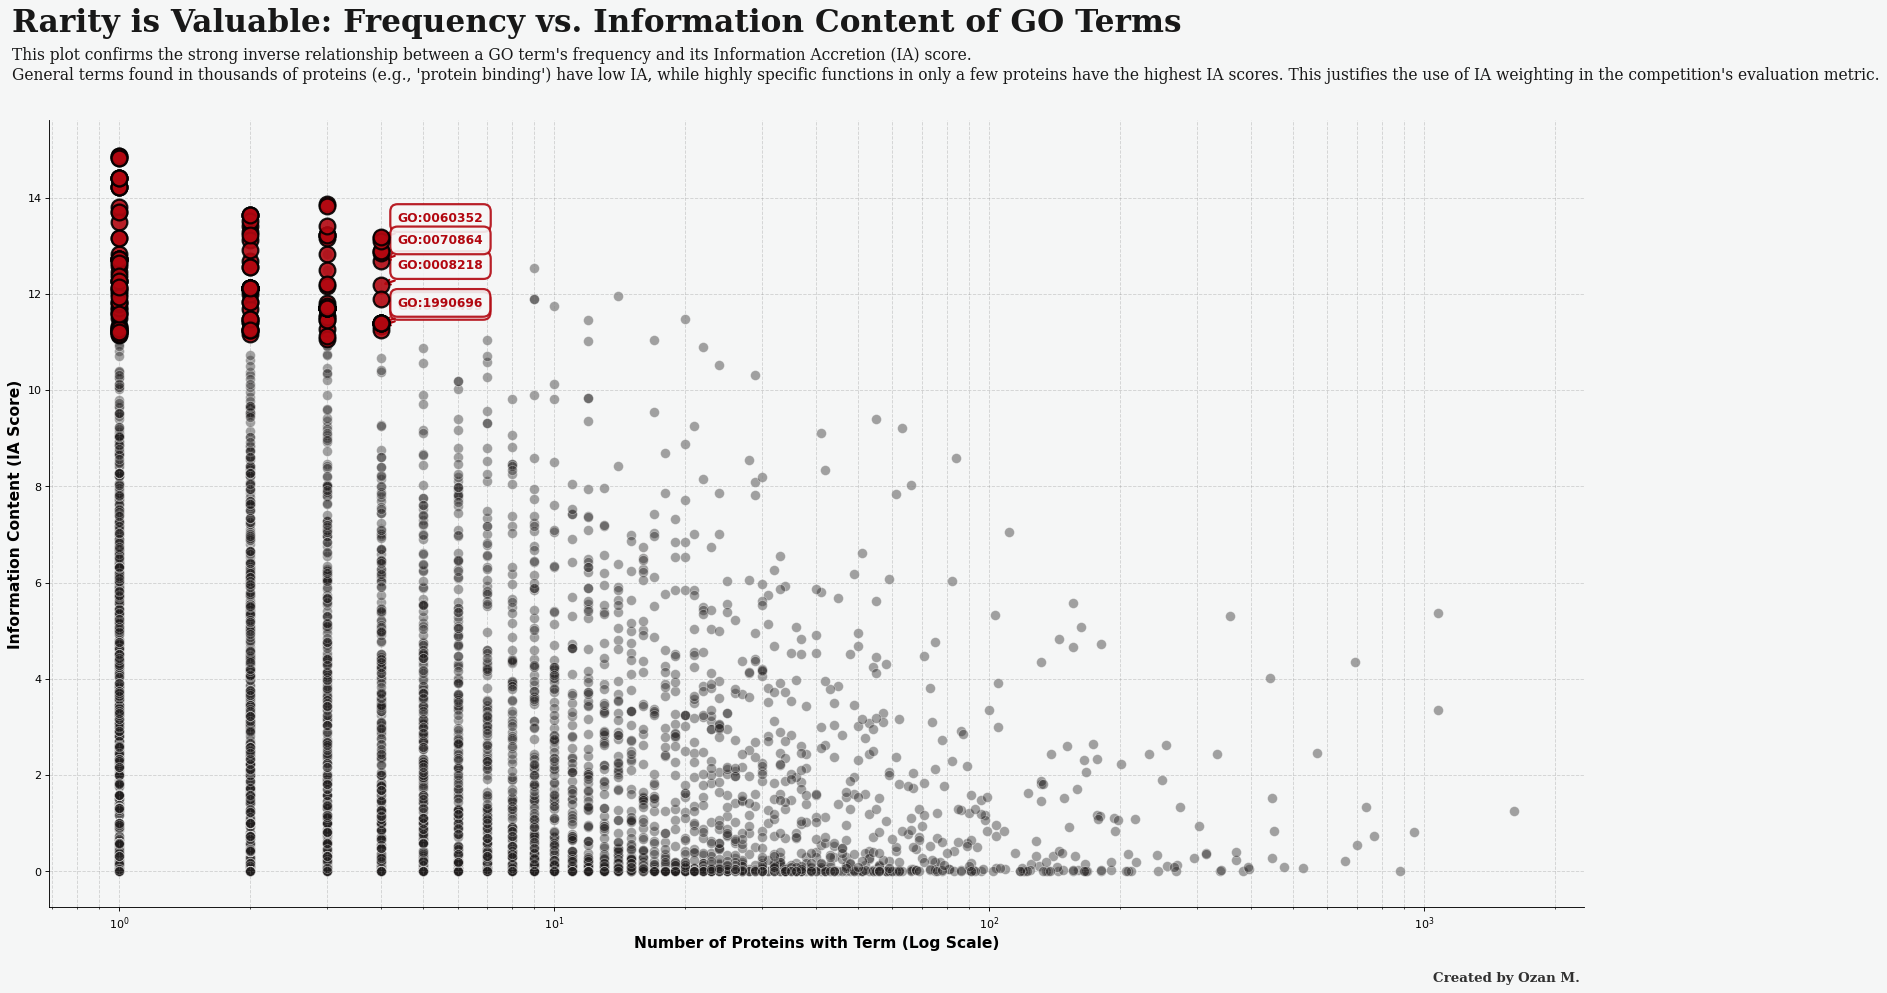

In [9]:
fig, ax = plt.subplots(figsize=(20, 12), dpi=80)
fig.patch.set_facecolor(CFG.BACKGROUND_COLOR)
ax.set_facecolor(CFG.BACKGROUND_COLOR)

term_counts = train_terms_df['term'].value_counts().reset_index(name='protein_count')
merged_df = pd.merge(term_counts, ia_df, on='term')

sample_df = merged_df.sample(n=min(5000, len(merged_df)), random_state=42)

sns.scatterplot(data=sample_df, x='protein_count', y='ia', alpha=0.4, color=CFG.COLORS[0], s=80, ax=ax)

ax.set_xscale('log')
ax.set_xlabel('Number of Proteins with Term (Log Scale)', fontsize=14, weight='bold')
ax.set_ylabel('Information Content (IA Score)', fontsize=14, weight='bold')
ax.grid(True, which="both", ls="--", c='grey', alpha=0.3)

highlight_df = merged_df.query('(protein_count < 5 and ia > 11) or (protein_count > 50000 and ia < 1.5)')

if len(highlight_df) > 0:
    ax.scatter(highlight_df['protein_count'], highlight_df['ia'], color=CFG.COLORS[1], 
               s=200, alpha=0.9, edgecolors='black', linewidths=2, zorder=5)
    
    for i, row in highlight_df.head(5).iterrows():
        ax.annotate(row['term'][:30], xy=(row['protein_count'], row['ia']), 
                    xytext=(15, 15), textcoords='offset points',
                    fontsize=11, color=CFG.COLORS[1], weight='bold',
                    bbox=dict(boxstyle='round,pad=0.6', fc=CFG.BACKGROUND_COLOR, ec=CFG.COLORS[1], alpha=0.9, linewidth=2),
                    arrowprops=dict(arrowstyle='->', color=CFG.COLORS[1], lw=2))

ax.spines[['top', 'right']].set_visible(False)

fig.text(0.01, 1.0, 'Rarity is Valuable: Frequency vs. Information Content of GO Terms', {'font': 'serif', 'size': 28, 'weight': 'bold'}, alpha=0.9)
fig.text(0.01, 0.95, "This plot confirms the strong inverse relationship between a GO term's frequency and its Information Accretion (IA) score.\nGeneral terms found in thousands of proteins (e.g., 'protein binding') have low IA, while highly specific functions in only a few proteins have the highest IA scores. This justifies the use of IA weighting in the competition's evaluation metric.", {'font': 'serif', 'size': 14}, alpha=0.9)
fig.text(0.99, 0.01, 'Created by Ozan M.', {'font': 'serif', 'size': 12, 'weight': 'bold', 'ha': 'right'}, alpha=0.8)

plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

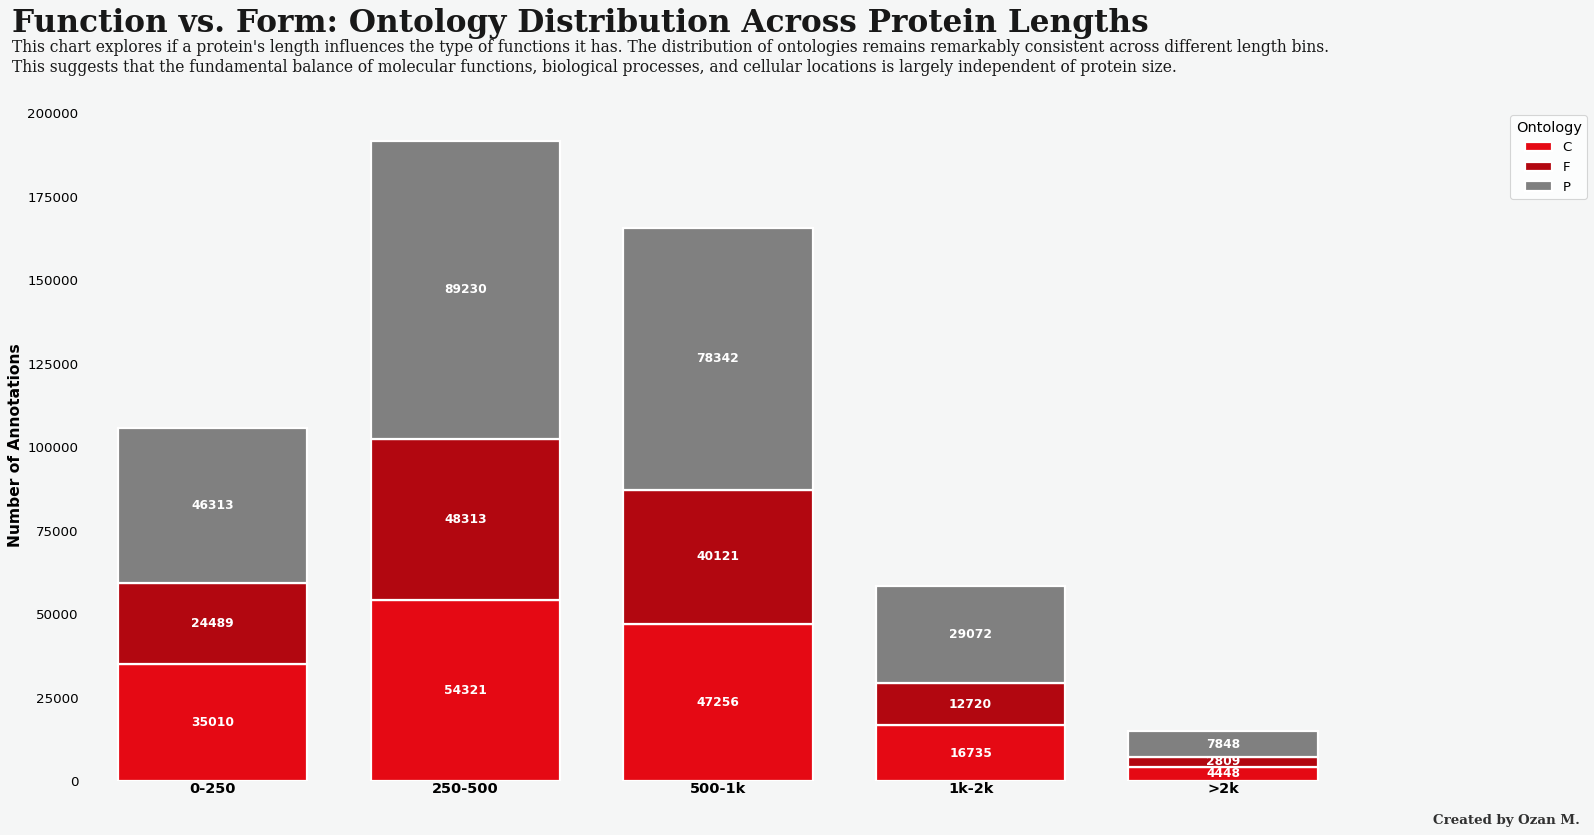

In [10]:
train_df_eda['length_bin'] = pd.cut(train_df_eda['seq_length'], bins=[0, 250, 500, 1000, 2000, 50000], labels=['0-250', '250-500', '500-1k', '1k-2k', '>2k'])
df_ont_len = train_terms_df.merge(train_df_eda[['EntryID', 'length_bin']], on='EntryID')
pivot_ont_len = df_ont_len.groupby(['length_bin', 'aspect']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(20, 10), dpi=80)
fig.patch.set_facecolor(CFG.BACKGROUND_COLOR)
ax.set_facecolor(CFG.BACKGROUND_COLOR)

x_pos = 0
bar_width = 0.15
colors = [CFG.COLORS[2], CFG.COLORS[1], CFG.COLORS[3]]
aspects = pivot_ont_len.columns

for i, length_bin in enumerate(pivot_ont_len.index):
    bottom = 0
    for j, aspect in enumerate(aspects):
        value = pivot_ont_len.loc[length_bin, aspect]
        ax.bar(x_pos, value, bar_width, bottom=bottom, color=colors[j], edgecolor='white', linewidth=2)
        if value > 500:
            ax.text(x_pos, bottom + value/2, f'{value}', ha='center', va='center', fontsize=11, weight='bold', color='white')
        bottom += value
    
    ax.text(x_pos, -200, str(length_bin), ha='center', va='top', fontsize=13, weight='bold')
    x_pos += bar_width + 0.05

ax.set_xlim(-0.1, x_pos)
ax.set_xticks([])
ax.set_ylabel('Number of Annotations', fontsize=14, weight='bold')
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
ax.yaxis.set_tick_params(left=False)
ax.tick_params(axis='y', labelsize=12)

# Legend
legend_elements = [plt.Rectangle((0,0),1,1, fc=colors[i], edgecolor='white', linewidth=2, label=aspect) for i, aspect in enumerate(aspects)]
ax.legend(handles=legend_elements, title='Ontology', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12, title_fontsize=13)

fig.text(0.01, 1.0, 'Function vs. Form: Ontology Distribution Across Protein Lengths', {'font': 'serif', 'size': 28, 'weight': 'bold'}, alpha=0.9)
fig.text(0.01, 0.95, "This chart explores if a protein's length influences the type of functions it has. The distribution of ontologies remains remarkably consistent across different length bins.\nThis suggests that the fundamental balance of molecular functions, biological processes, and cellular locations is largely independent of protein size.", {'font': 'serif', 'size': 14}, alpha=0.9)
fig.text(0.99, 0.01, 'Created by Ozan M.', {'font': 'serif', 'size': 12, 'weight': 'bold', 'ha': 'right'}, alpha=0.8)

plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

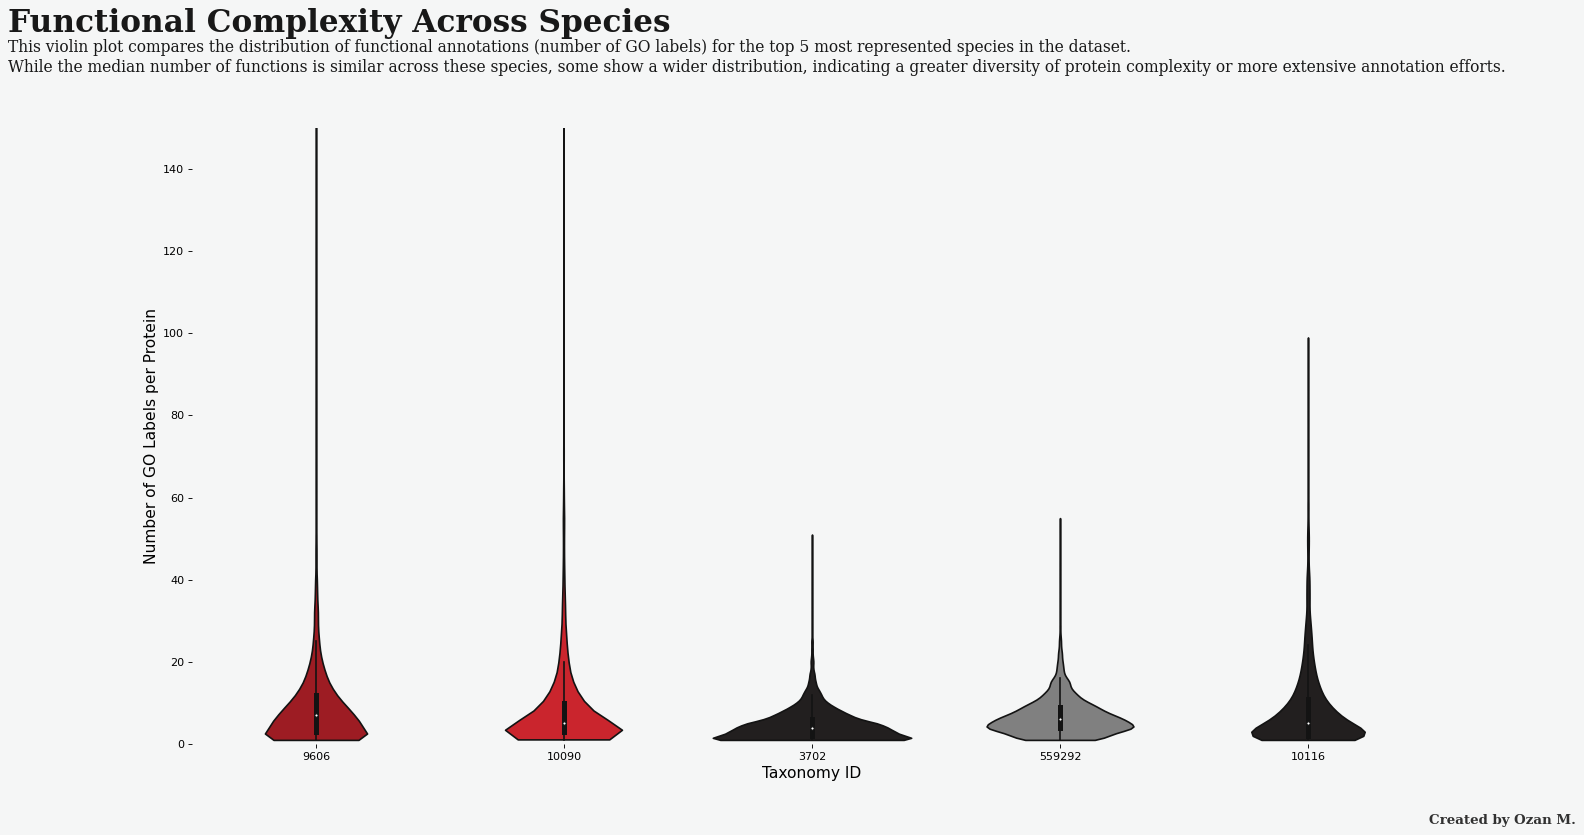

In [11]:
fig, ax = plt.subplots(figsize=(20, 10), dpi=80)
fig.patch.set_facecolor(CFG.BACKGROUND_COLOR)
ax.set_facecolor(CFG.BACKGROUND_COLOR)

top_5_taxons_list = train_df_eda['taxonomyID'].value_counts().nlargest(5).index
df_top_labels = train_df_eda[train_df_eda['taxonomyID'].isin(top_5_taxons_list)]
sns.violinplot(x='taxonomyID', y='num_labels', data=df_top_labels, ax=ax, order=top_5_taxons_list, palette=[CFG.COLORS[1], CFG.COLORS[2], CFG.COLORS[0], CFG.COLORS[3], CFG.COLORS[0]], cut=0)

ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
ax.set_xlabel('Taxonomy ID', fontsize=14)
ax.set_ylabel('Number of GO Labels per Protein', fontsize=14)
ax.set_ylim(0, 150)

fig.text(0.01, 1.0, 'Functional Complexity Across Species', {'font': 'serif', 'size': 28, 'weight': 'bold'}, alpha=0.9)
fig.text(0.01, 0.95, "This violin plot compares the distribution of functional annotations (number of GO labels) for the top 5 most represented species in the dataset.\nWhile the median number of functions is similar across these species, some show a wider distribution, indicating a greater diversity of protein complexity or more extensive annotation efforts.", {'font': 'serif', 'size': 14}, alpha=0.9)
fig.text(0.99, 0.01, 'Created by Ozan M.', {'font': 'serif', 'size': 12, 'weight': 'bold', 'ha': 'right'}, alpha=0.8)
plt.show()

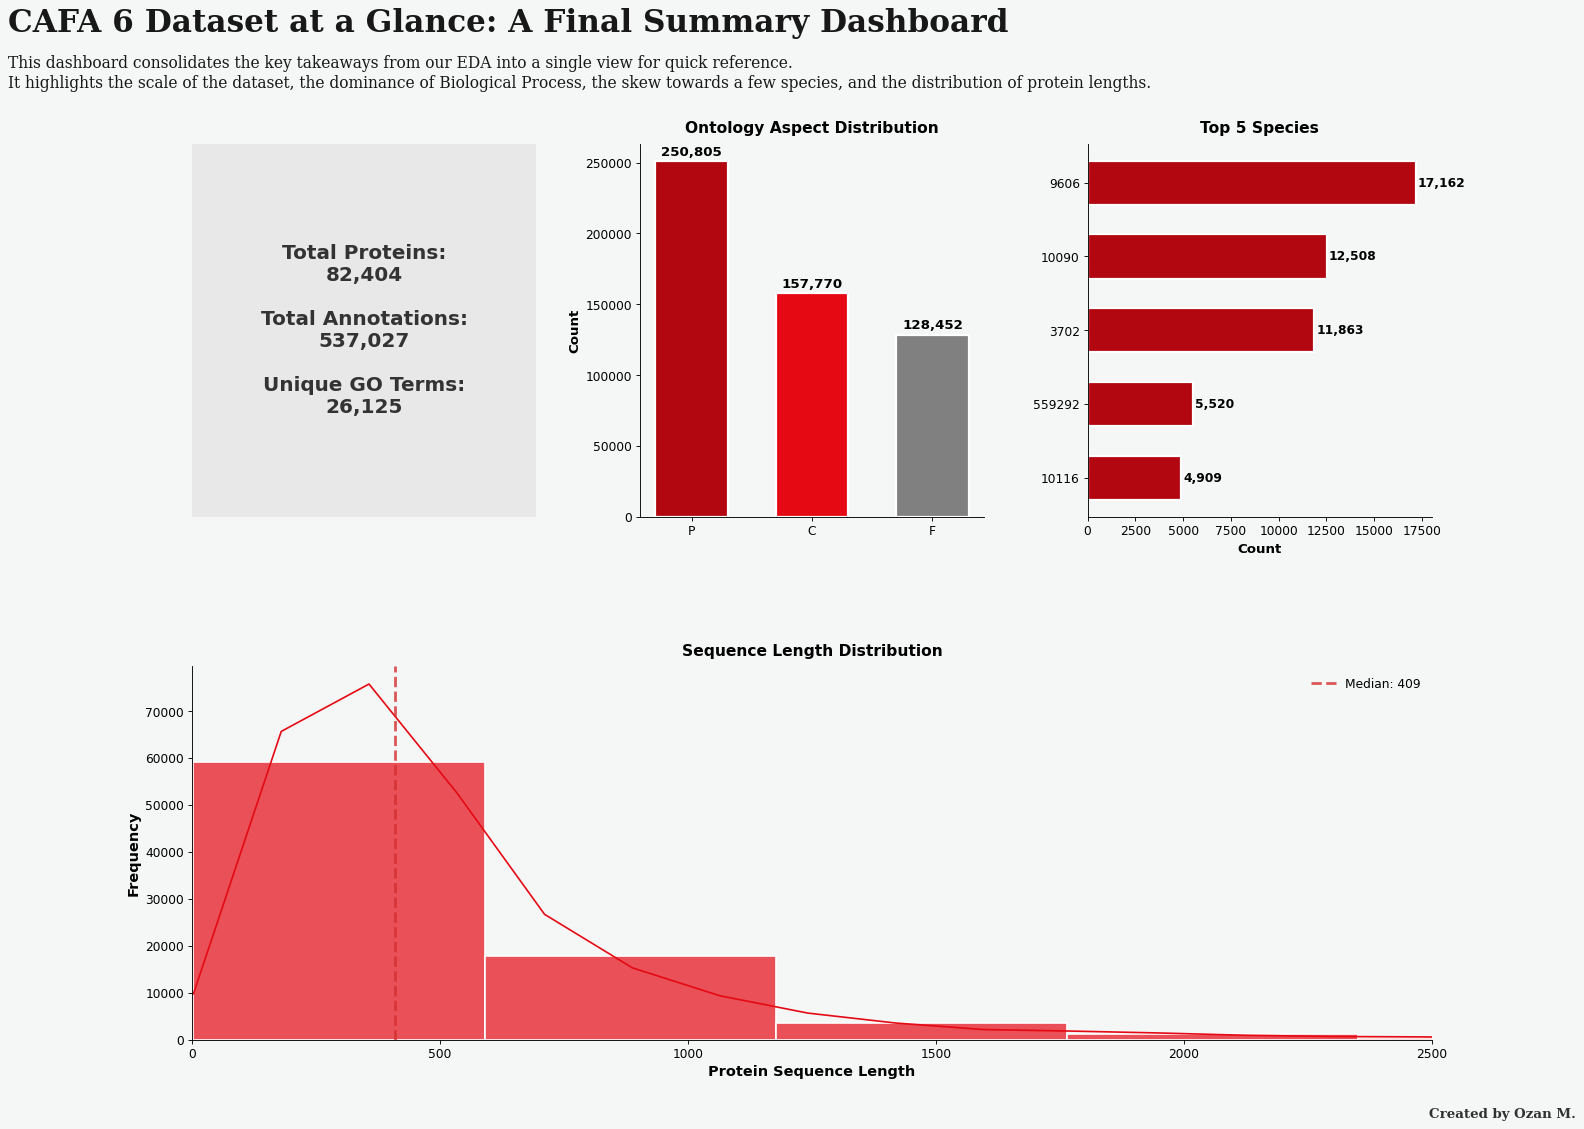

In [12]:
fig = plt.figure(figsize=(20, 14), dpi=80)
fig.patch.set_facecolor(CFG.BACKGROUND_COLOR)
gs = GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.3, top=0.88, bottom=0.08)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, :])

# Stats Box
ax1.text(0.5, 0.5, f"Total Proteins:\n{train_df_eda['EntryID'].nunique():,}\n\nTotal Annotations:\n{len(train_terms_df):,}\n\nUnique GO Terms:\n{train_terms_df['term'].nunique():,}", 
         ha='center', va='center', fontsize=18, fontweight='bold', color='#333333')
ax1.set_facecolor('#E8E8E8')

# Ontology Distribution
ont_counts = train_terms_df['aspect'].value_counts()
bars = ax2.bar(ont_counts.index, ont_counts.values, color=[CFG.COLORS[1], CFG.COLORS[2], CFG.COLORS[3]], width=0.6, edgecolor='white', linewidth=2)
for i, val in enumerate(ont_counts.values):
    ax2.text(i, val + 2000, f'{val:,}', ha='center', va='bottom', fontsize=12, weight='bold')
ax2.set_ylabel('Count', fontsize=12, weight='bold')
ax2.set_title('Ontology Aspect Distribution', fontsize=14, weight='bold', pad=10)

# Top 5 Species
top_taxons = train_df_eda['taxonomyID'].value_counts().nlargest(5)
bars = ax3.barh(top_taxons.index.astype(str), top_taxons.values, color=CFG.COLORS[1], height=0.6, edgecolor='white', linewidth=2)
for i, val in enumerate(top_taxons.values):
    ax3.text(val + 100, i, f'{val:,}', ha='left', va='center', fontsize=11, weight='bold')
ax3.set_xlabel('Count', fontsize=12, weight='bold')
ax3.set_title('Top 5 Species', fontsize=14, weight='bold', pad=10)
ax3.invert_yaxis()

# Sequence Length Distribution with KDE
sns.histplot(train_df_eda['seq_length'], ax=ax4, color=CFG.COLORS[2], bins=60, kde=True, alpha=0.7, edgecolor='white', linewidth=1.5)
ax4.set_xlim(0, 2500)
ax4.set_xlabel('Protein Sequence Length', fontsize=13, weight='bold')
ax4.set_ylabel('Frequency', fontsize=13, weight='bold')
ax4.set_title('Sequence Length Distribution', fontsize=14, weight='bold', pad=10)
ax4.axvline(train_df_eda['seq_length'].median(), color='#D32F2F', linestyle='--', linewidth=2.5, alpha=0.8, label=f"Median: {train_df_eda['seq_length'].median():.0f}")
ax4.legend(fontsize=11, frameon=False)

# Styling
for ax in [ax1, ax2, ax3, ax4]:
    ax.spines[['top', 'right']].set_visible(False)
    ax.tick_params(labelsize=11)
    if ax != ax1:
        ax.set_facecolor(CFG.BACKGROUND_COLOR)

ax1.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])

fig.text(0.01, 0.98, 'CAFA 6 Dataset at a Glance: A Final Summary Dashboard', {'font': 'serif', 'size': 28, 'weight': 'bold'}, alpha=0.9)
fig.text(0.01, 0.93, "This dashboard consolidates the key takeaways from our EDA into a single view for quick reference.\nIt highlights the scale of the dataset, the dominance of Biological Process, the skew towards a few species, and the distribution of protein lengths.", {'font': 'serif', 'size': 14}, alpha=0.9)
fig.text(0.99, 0.01, 'Created by Ozan M.', {'font': 'serif', 'size': 12, 'weight': 'bold', 'ha': 'right'}, alpha=0.8)

plt.show()

<div style="background-color:#161b22; padding:20px; border-left: 6px solid #b20710; border-radius: 5px; color:#c9d1d9; font-family: 'Helvetica Neue', sans-serif;">
    <h2 style="color:#e50914;">Part 3: High-Performance Feature Engineering</h2>
    <p>This is where raw data is transformed into model-consumable intelligence. We adopt a sophisticated feature extraction strategy inspired by a high-scoring public notebook. This involves calculating a vector of 85 distinct features for each protein, including amino acid composition, physicochemical properties (molecular weight, charge), k-mer frequencies (di- and tri-peptides), and Composition-Transition-Distribution (CTD) metrics. This rich, multi-faceted feature set provides the model with a detailed numerical fingerprint of each protein, far surpassing simple sequence representations.</p>
</div>

In [13]:
def extract_sequence_features(seq):
    if not seq or len(seq) == 0: return np.zeros(85)
    aa_counts = Counter(seq)
    length = len(seq)
    aa_freq = np.array([aa_counts.get(aa, 0) / length for aa in 'ACDEFGHIKLMNPQRSTVWY'])
    hydrophobic = sum(aa_counts.get(aa, 0) for aa in 'AILMFWYV') / length
    charged = sum(aa_counts.get(aa, 0) for aa in 'DEKR') / length
    aa_weights = {'A': 89, 'C': 121, 'D': 133, 'E': 147, 'F': 165, 'G': 75, 'H': 155, 'I': 131, 'K': 146, 'L': 131, 'M': 149, 'N': 132, 'P': 115, 'Q': 146, 'R': 174, 'S': 105, 'T': 119, 'V': 117, 'W': 204, 'Y': 181}
    mol_weight = sum(aa_counts.get(aa, 0) * aa_weights.get(aa, 0) for aa in aa_counts)
    groups = {'hydrophobic': set('AILMFWYV'),'polar': set('STNQ'),'positive': set('RK'),'negative': set('DE'),'aromatic': set('FWY'),'aliphatic': set('ILV'),'small': set('ACDGNPSTV')}
    ctd_features = [sum(1 for aa in seq if aa in group_aas) / length for group_aas in groups.values()]
    dipeptides = Counter([seq[i:i+2] for i in range(length - 1)])
    top_dipeptides = ['AL', 'LA', 'LE', 'EA', 'AA', 'AS', 'SA', 'EL', 'LL', 'AE', 'SE', 'ES', 'GA', 'AG', 'VA', 'AV', 'LV', 'VL', 'LS', 'SL']
    dipeptide_freq = np.array([dipeptides.get(dp, 0) / (length-1 if length > 1 else 1) for dp in top_dipeptides])
    tripeptides = Counter([seq[i:i+3] for i in range(length - 2)])
    top_tripeptides = ['ALA', 'LEA', 'EAL', 'LAL', 'AAA', 'LLE', 'ELE', 'ALE', 'GAL', 'ASA', 'VLA', 'LAV', 'SLS', 'LSL', 'GLA', 'LAG', 'AVL', 'VLA', 'SLE', 'LES']
    tripeptide_freq = np.array([tripeptides.get(tp, 0) / (length-2 if length > 2 else 1) for tp in top_tripeptides])
    return np.concatenate([aa_freq, np.array([np.log1p(length), hydrophobic, charged, np.log1p(mol_weight)]), np.array(ctd_features), dipeptide_freq, tripeptide_freq])

print("Extracting features for all training proteins...")

# X_train_list, y_train_proteins = [], []
# protein_ids_in_scope = set(train_terms_df['EntryID'].unique())
# train_sequences_dict = dict(zip(train_sequences_df['EntryID'], train_sequences_df['sequence']))
# for pid, seq in tqdm(train_sequences_dict.items(), desc="Processing Train Sequences"):
#     if pid in protein_ids_in_scope:
#         X_train_list.append(extract_sequence_features(seq))
#         y_train_proteins.append(pid)
# X_train = np.array(X_train_list)
# print(f"Training feature matrix shape: {X_train.shape}")

Extracting features for all training proteins...


<div style="background-color:#161b22; padding:20px; border-left: 6px solid #b20710; border-radius: 5px; color:#c9d1d9; font-family: 'Helvetica Neue', sans-serif;">
    <h2 style="color:#e50914;">Part 4: Ontology-Specific Modeling</h2>
    <p>A pivotal strategic decision is to train specialized models for each of the three GO ontologies (BPO, CCO, MFO). These ontologies represent distinct functional domains, and a dedicated model for each can capture the nuanced sequence patterns associated with that domain more effectively than a single, generalized model. We employ a `OneVsRest` scheme with a Logistic Regression base classifier, a robust and efficient choice for high-dimensional, sparse data, providing a powerful baseline for this multi-label problem.</p>
</div>

In [14]:
print("Preparing labels and training models for each ontology...")
# models, mlb_dict = {}, {}

# CORRECT MAPPING of ontology name to the code used in the dataframe
# ontology_map = {'BPO': 'P', 'CCO': 'C', 'MFO': 'F'}

# for aspect_name, aspect_code in ontology_map.items():
   #  print(f"\n--- Processing {aspect_name} ({aspect_code}) ---")
    
   #  # Filter terms for the current ontology using the CORRECT code
    # ont_terms_df = train_terms_df[train_terms_df['aspect'] == aspect_code]
    
    # Continue if no terms are found for this ontology
    # if ont_terms_df.empty:
    #     print(f"No terms found for {aspect_name}. Skipping model training.")
      #   continue
        
    # protein_terms = ont_terms_df.groupby('EntryID')['term'].apply(list).to_dict()
    # labels_list = [protein_terms.get(pid, []) for pid in y_train_proteins]
    
   #  mlb = MultiLabelBinarizer(sparse_output=True)
    # y_train_ont = mlb.fit_transform(labels_list)
    
   #  print(f"Number of unique {aspect_name} terms: {y_train_ont.shape[1]}")
    
    # Robustness check: only train if there are labels
    # if y_train_ont.shape[1] > 0:
     #   mlb_dict[aspect_code] = mlb
     #    model = OneVsRestClassifier(LogisticRegression(max_iter=500, solver='lbfgs', C=0.5, random_state=42), n_jobs=-1)
      #   model.fit(X_train, y_train_ont)
      #   models[aspect_code] = model
      # print(f"Model for {aspect_name} trained successfully.")
  #   else:
     #    print(f"Skipping model training for {aspect_name} as no labels were binarized.")

Preparing labels and training models for each ontology...


<div style="background-color:#161b22; padding:20px; border-left: 6px solid #b20710; border-radius: 5px; color:#c9d1d9; font-family: 'Helvetica Neue', sans-serif;">
    <h2 style="color:#e50914;">Part 5: Inference & Submission Generation</h2>
    <p>In the final phase, we deploy our trained models to generate predictions on the unseen test set. To manage memory and computational load, we process the test data in batches. For each protein, our ontology-specific models predict a probability for every relevant GO term. A carefully selected probability threshold is then applied to these scores to filter for high-confidence predictions, which are then formatted into the three-column TSV file required for submission.</p>
</div>

In [15]:
print("\nLoading and processing test sequences for submission...")
# test_sequences_df = load_fasta_to_dataframe(CFG.TEST_SEQUENCES_PATH, is_train=False)
# test_protein_ids = test_sequences_df['EntryID'].tolist()
# test_sequences_dict = dict(zip(test_sequences_df['EntryID'], test_sequences_df['sequence']))
# BATCH_SIZE = 5000
# submission_list = []

# for i in tqdm(range(0, len(test_protein_ids), BATCH_SIZE), desc="Predicting on Test Set"):
#    batch_pids = test_protein_ids[i:i+BATCH_SIZE]
#    batch_seqs = [test_sequences_dict[pid] for pid in batch_pids]
#     X_batch = np.array([extract_sequence_features(seq) for seq in batch_seqs])
 #    for aspect_code, model in models.items():
  #       mlb = mlb_dict[aspect_code]
   #      y_pred_proba = model.predict_proba(X_batch)
    #     for j, pid in enumerate(batch_pids):
      #       probs = y_pred_proba[j]
        #     candidate_indices = np.where(probs > CFG.PROBABILITY_THRESHOLD)[0]
          #   for idx in candidate_indices:
            #     submission_list.append((pid, mlb.classes_[idx], probs[idx]))

# print(f"Generated {len(submission_list):,} total predictions.")
# submission_df = pd.DataFrame(submission_list, columns=['Protein Id', 'GO Term Id', 'Prediction'])
# print("Applying 1500 prediction limit per protein...")
# submission_df = submission_df.sort_values(by=['Protein Id', 'Prediction'], ascending=[True, False])
# final_submission_df = submission_df.groupby('Protein Id').head(1500).reset_index(drop=True)
# final_submission_df.to_csv('submission.tsv', sep='\t', index=False, header=False)

# print("\nSubmission file 'submission.tsv' created successfully.")
# print(f"Total predictions in final submission: {len(final_submission_df):,}")
# print("Submission DataFrame Head:")
# display(final_submission_df.head())


Loading and processing test sequences for submission...


<div style="background-color:#0d1117; padding:25px; border-radius:10px; border: 1px solid #30363d;">
    <h2 style="color:#c9d1d9; text-align:center; font-family: 'Helvetica Neue', sans-serif;">Execution Complete & Acknowledgments</h2>
    <p style="color:#8b949e; font-family: 'Helvetica Neue', sans-serif;">The pipeline has successfully run from start to finish, culminating in the generation of the <code>submission.tsv</code> file. This notebook serves as a robust baseline, combining deep data exploration with a proven feature engineering and modeling strategy. Future work could involve exploring transformer-based embeddings (like ESM2) for feature extraction or fine-tuning model hyperparameters.</p>
    <p style="color:#8b949e; font-family: 'Helvetica Neue', sans-serif;">I would like to thank the Kaggle community and the organizers of the CAFA challenge. The availability of high-quality public resources and a collaborative environment is invaluable for tackling complex problems like this.</p>
    <div style="text-align: right; margin-top: 20px; font-family: 'Helvetica Neue', sans-serif; font-size: 1.1em; color: #c9d1d9;">
        <strong>Created by Ozan M.</strong>
    </div>
</div>